In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl

from src.data.affectnet_datamodule import AffectNetAUDataModule

In [3]:
pl

label_type = ['arousal', 'valence', 'expression']
data_basepth = Path('../data/')
val_split = 0.1
batch_size = 100

In [4]:
dm = AffectNetAUDataModule(label_type, data_basepth, val_split, batch_size)
dm.prepare_data()
dm.setup(stage=None)

In [5]:
train_ds = dm.train_dataset.dataset[dm.train_dataset.indices]
val_ds = dm.val_dataset.dataset[dm.val_dataset.indices]
test_ds = dm.test_dataset[np.arange(len(dm.test_dataset))]

In [60]:
df_train = pd.DataFrame(data=train_ds[0], columns=dm.feature_names)
df_train[label_type] = train_ds[1]
df_train['img_id'] = train_ds[2]
df_train = df_train.astype({"expression": int}, errors='raise') 

df_val = pd.DataFrame(data=val_ds[0], columns=dm.feature_names)
df_val[label_type] = val_ds[1]
df_val['img_id'] = val_ds[2]
df_val = df_val.astype({"expression": int}, errors='raise') 

df_test = pd.DataFrame(data=test_ds[0], columns=dm.feature_names)
df_test[label_type] = test_ds[1]
df_test['img_id'] = test_ds[2]
df_test = df_test.astype({"expression": int}, errors='raise') 

df_train['partition'] = 'train'
df_val['partition'] = 'val'
df_test['partition'] = 'test'

df_full = pd.concat([df_train, df_val, df_test], axis=0)

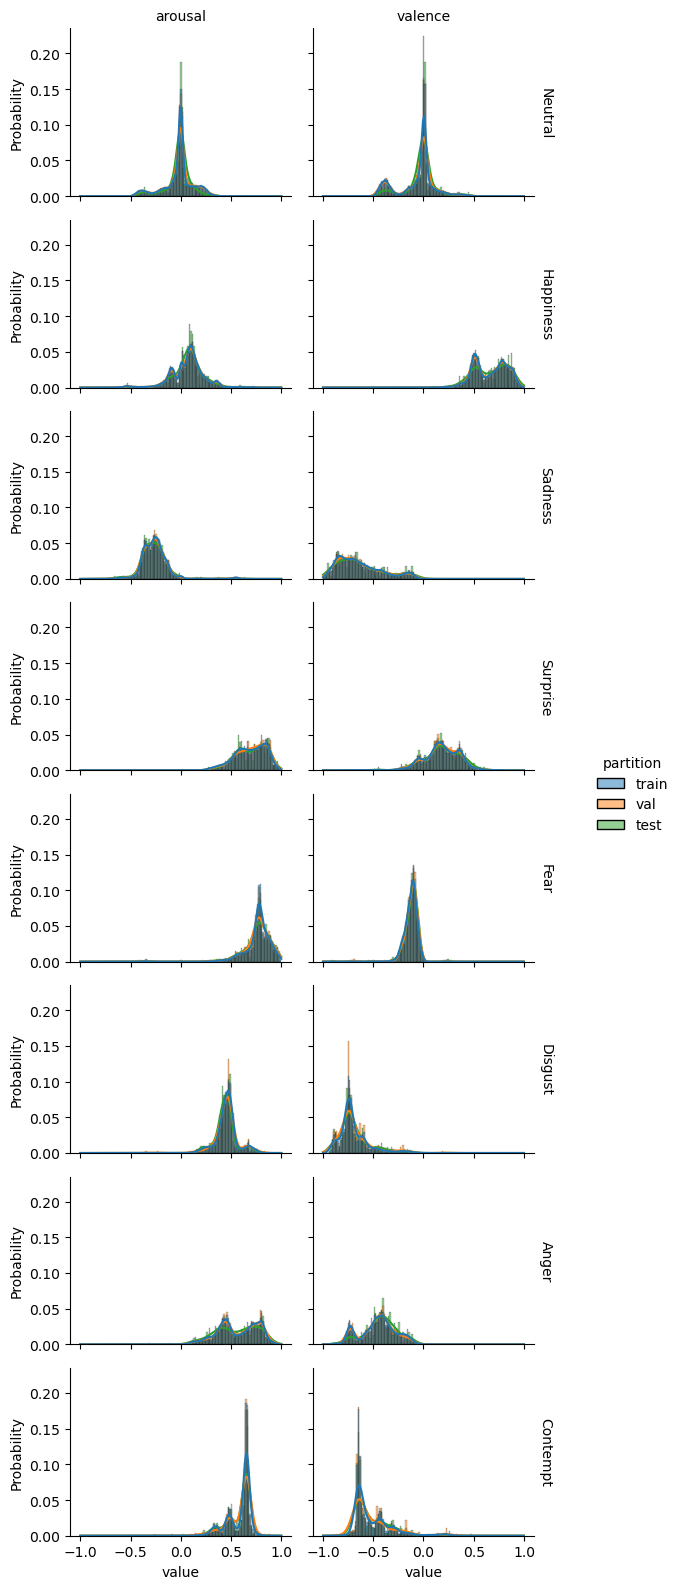

In [71]:
df_histplot_melt = df_full[['arousal', 'valence', 'partition', 'expression', 'img_id']].melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm.expression_labels)}
df_histplot_melt['expression'] = df_histplot_melt['expression'].map(label_map)
g = sns.displot(
    df_histplot_melt, x="value", row='expression', col="variable", hue="partition",
    kind='hist', stat='probability', common_norm=False, kde=True,
    aspect=1.5, height=2, row_order=dm.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}');

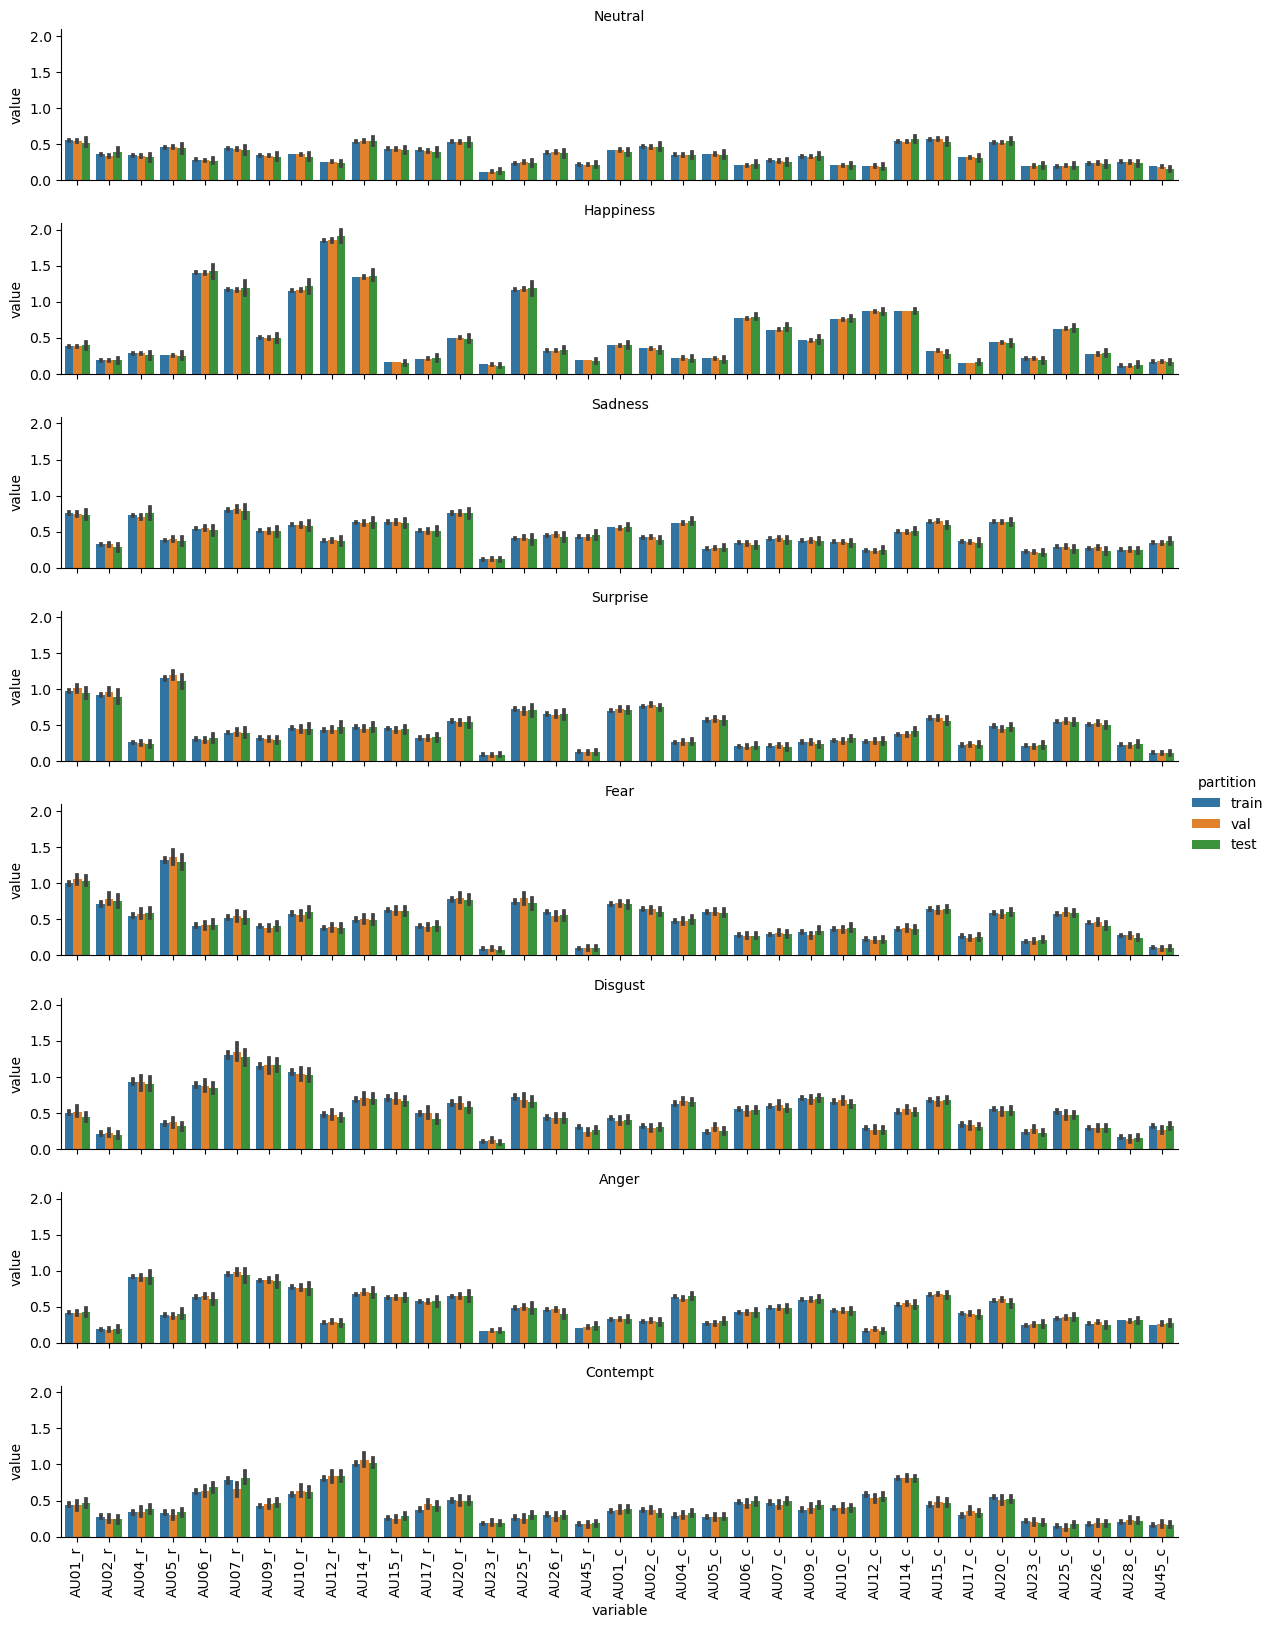

In [74]:
df_catplot_melt = df_full.drop(['arousal', 'valence'], axis=1).melt(id_vars=['partition', 'img_id', 'expression'])
label_map = {i: name for i, name in enumerate(dm.expression_labels)}
df_catplot_melt['expression'] = df_catplot_melt['expression'].map(label_map)
g = sns.catplot(
    data=df_catplot_melt, x='variable', y='value', hue='partition', row='expression', kind='bar', 
    aspect=6, height=2, row_order=dm.expression_labels, 
    facet_kws = {'margin_titles': True}
)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xticklabels(rotation=90);